# Spam Email Classification Notebook with Step-by-Step Outputs


In [1]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; 

# 1. Data Loading and Inspection

In [2]:
import pandas as pd

df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df = df[['text', 'target']]
df['target'] = df['target'].map({'ham': 0, 'spam': 1})

# Display results
print("First 5 rows of dataset:")
display(df.head())
print("\nTarget distribution:")
print(df['target'].value_counts())


First 5 rows of dataset:


,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0



Target distribution:
target
0    4825
1     747
Name: count, dtype: int64


# 2. Preprocessing: TF-IDF and (optional) PCA


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# TF-IDF transform
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Display TF-IDF matrix shape
print("TF-IDF matrix shape:", X_tfidf.shape)

# Optional PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Display explained variance
print("Explained variance ratio of 2 PCs:", pca.explained_variance_ratio_)


TF-IDF matrix shape: (5572, 5000)
Explained variance ratio of 2 PCs: [0.01044248 0.00898265]


# 3. Unsupervised Learning: K-means and Hierarchical Clustering


In [4]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd

# K-means
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_pca)
df['kmeans_cluster'] = kmeans.labels_

# Hierarchical Clustering
link = linkage(X_pca, method='ward')
df['hier_cluster'] = fcluster(link, 2, criterion='maxclust')

# Display cluster counts
print("K-means cluster counts:")
print(df['kmeans_cluster'].value_counts())
print("\nHierarchical cluster counts:")
print(df['hier_cluster'].value_counts())


K-means cluster counts:
kmeans_cluster
1    4190
0    1382
Name: count, dtype: int64

Hierarchical cluster counts:
hier_cluster
2    4254
1    1318
Name: count, dtype: int64


# 4. Visualization


First few PC values:


,PC1,PC2
0,-0.064907,-0.021386
1,-0.178204,-0.061449
2,-0.037122,-0.008891
3,-0.089345,-0.040942
4,-0.023758,-0.031443


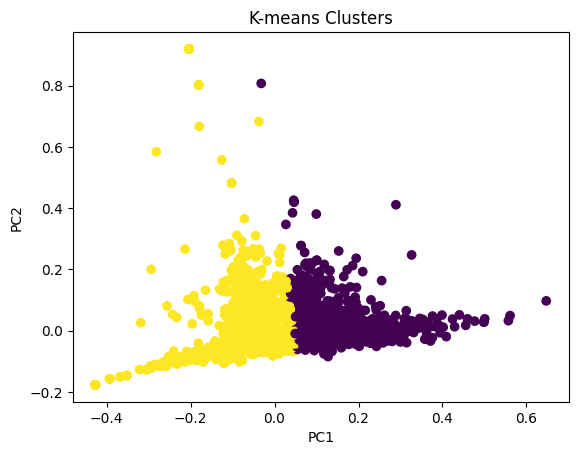

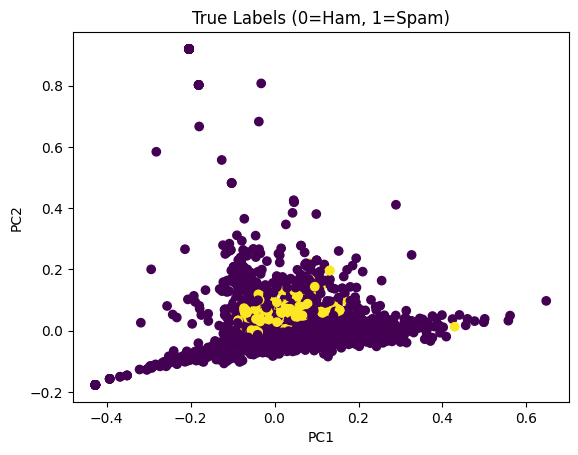

In [5]:
import matplotlib.pyplot as plt

# Prepare DataFrame of PCs
pc_df = pd.DataFrame(X_pca, columns=['PC1','PC2'])
print("First few PC values:")
display(pc_df.head())

# Plot by K-means clusters
plt.figure()
plt.scatter(pc_df['PC1'], pc_df['PC2'], c=df['kmeans_cluster'])
plt.title('K-means Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Plot by true labels
plt.figure()
plt.scatter(pc_df['PC1'], pc_df['PC2'], c=df['target'])
plt.title('True Labels (0=Ham, 1=Spam)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# 5. Word Embeddings and Data Preparation for Supervised Learning


In [6]:
import gensim.downloader as api
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split

# Tokenize text
tokenized = [text.split() for text in df['text']]

# Train Word2Vec
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=2, workers=4, seed=42)

# Function to embed texts
def embed_text(model, texts):
    return np.array([
        np.mean([model.wv[word] for word in text if word in model.wv] or [np.zeros(model.vector_size)], axis=0)
        for text in texts
    ])

X_w2v = embed_text(w2v_model, tokenized)

# Display a sample embedding
print("Sample embedding vector (first email):")
print(X_w2v[0])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_w2v, df['target'], test_size=0.2, random_state=42)
print("\nTrain/test sizes:", X_train.shape, X_test.shape)


Sample embedding vector (first email):
[ 0.2490906  -0.00358468 -0.12425725  0.15534182 -0.27914685  0.34077838
  0.16311264  0.22526227 -0.19183114 -0.07767813 -0.44641188  0.30736122
 -0.13844658  0.4590649  -0.07073464 -0.17338665  0.07552769 -0.70272362
 -0.23694392 -0.177579    0.05691171  0.06934582  0.19061221  0.52267563
  0.44225127 -0.20245866 -0.33971384  0.06231502 -0.32301712 -0.28648552
 -0.14981188 -0.13025843  0.15546094 -0.19300337  0.03150485 -0.25439733
  0.32286677 -0.70474678 -0.17165777  0.19028856  0.13606922 -0.07946669
  0.47264144 -0.35133654  0.1212637   0.04838384  0.2712349   0.43930626
  0.67263693 -0.35933265 -0.02058305 -0.90923172 -0.14028887 -0.07343403
  0.24409309 -0.11711304 -0.37612459  0.11065829 -0.1166093   0.31381053
  0.07264859 -0.08154818 -0.56243175  0.27313647  0.22797747  0.26187783
  0.08205446 -0.38687697 -0.56774336 -0.00684815 -0.05523307 -0.04320893
 -0.18340172 -0.2297249   0.20170079 -0.10070294 -0.02510404 -0.27775571
 -0.0666935 

# 6. Supervised Learning Models


In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

models = {
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GBM': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"=== {name} ===")
    print(classification_report(y_test, preds))


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.93      0.53      0.67       965
           1       0.20      0.75      0.31       150

    accuracy                           0.56      1115
   macro avg       0.57      0.64      0.49      1115
weighted avg       0.83      0.56      0.63      1115

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       965
           1       0.93      0.61      0.73       150

    accuracy                           0.94      1115
   macro avg       0.94      0.80      0.85      1115
weighted avg       0.94      0.94      0.94      1115

=== GBM ===
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       965
           1       0.80      0.55      0.65       150

    accuracy                           0.92      1115
   macro avg       0.87      0.76      0.80      1115
weighted avg       0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       965
           1       0.84      0.69      0.76       150

    accuracy                           0.94      1115
   macro avg       0.90      0.83      0.86      1115
weighted avg       0.94      0.94      0.94      1115



# 7. Hyperparameter Optimization using GridSearchCV


In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'GBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    }
}

best_params = {}

for name, model in [('Random Forest', RandomForestClassifier(random_state=42)),
                    ('GBM', GradientBoostingClassifier(random_state=42)),
                    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]:
    print(f"Running GridSearch for {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}: {grid.best_params_}\n")
    best_params[name] = grid.best_params_

print("Hyperparameter optimization complete. Best parameters:")
print(best_params)


Running GridSearch for Random Forest...
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

Running GridSearch for GBM...
Best params for GBM: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

Running GridSearch for XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:55:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

Hyperparameter optimization complete. Best parameters:
{'Random Forest': {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}, 'GBM': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}, 'XGBoost': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}}
